## Chapter 11: Principles of Feature Learning

# 11.7 Testing data

You can toggle the code on and off in this presentation via the button below.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

- As with training data, it is also possible to overfit to validation data as well during the cross-validation procedure. 

- Provided the dataset is large enough, we can ameliorate this risk by splitting our original data into not two sets (training and validation), but three: <u><b>training</b></u>, <u><b>validation</b></u>, and <u><b>testing</b></u> sets.

<br><br>
<figure align="center">
    <img src= '../../mlrefined_images/nonlinear_superlearn_images/testing.png' width="80%"/>
</figure>


In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.7.1  Overfitting validation data 

In Section 11.2 we learned how - as a measurement tool - training error fails to help us properly identify when a model has sufficient capacity and is tuned appropriately to represent a given dataset.  In particular we saw how - given a high capacity model - it is very easy to *overfit* a dataset by proper optimization.  There we saw how overfitting model, that is one that achieves minimum training error, reprsents the training data we currently have incredibly well, but simultaneously represents the phenomenon underlying the data (as well as any future data similarly generated by it) very poorly.  

While not nearly as prevalent in practice, minimum validation error models can also lead to *overfitting* behavior.  In other words, we can also overfit to validation data.  To see how this can happen let us analyze an extreme two-class classification dataset.  As shown in the left panel below, this dataset of $P = 200$ points is *completely random*, there being no meaningful relationship whatsoever between the input and output (labels).  Indeed we created it by choosing $P = 200$ points randomly (uniformly) on the unit square and assigned labels to the points at random.  

Because we know that the underlying phenomenon generating this dataset is *completely random* no model - whether it has been found via cross-validation or otherwise - could ever allow us to correctly predict the label of future points more than $50\%$ of the time (better than chance).  In other words, no model could truly provide better than $50\%$ accuracy on random data such as this.  However this reality need not be reflected in an appropriately cross-validated model (i.e., one with minimum validation error for some split of the data).  Indeed in the right panel below we show the decision boundary of a cross-validated model (here we searched over a range of complete polynomials) for this dataset, where $\frac{1}{4}$ of the original data was used as validation, and color the regions according to the model's predictions.  This particular cross-validated model provides $60\%$ accuracy on the validation data, which perhaps at first glance is mysterious given our understanding of the data.  However this is because - even though it was chosen as the *validation-error minimizing model* - this model *overfits* the original data.  In doing so - just like overfitting models chosen via training-error minimization - we have a chosen a model that provides a poor representation for future data generated by the same (in this case random) process.  In other words, here validation error clearly fails to truly capture how well our model will perform in general.

accuracy on validation set 60.0%
accuracy on entire dataset 45.5%


<IPython.core.display.Javascript object>


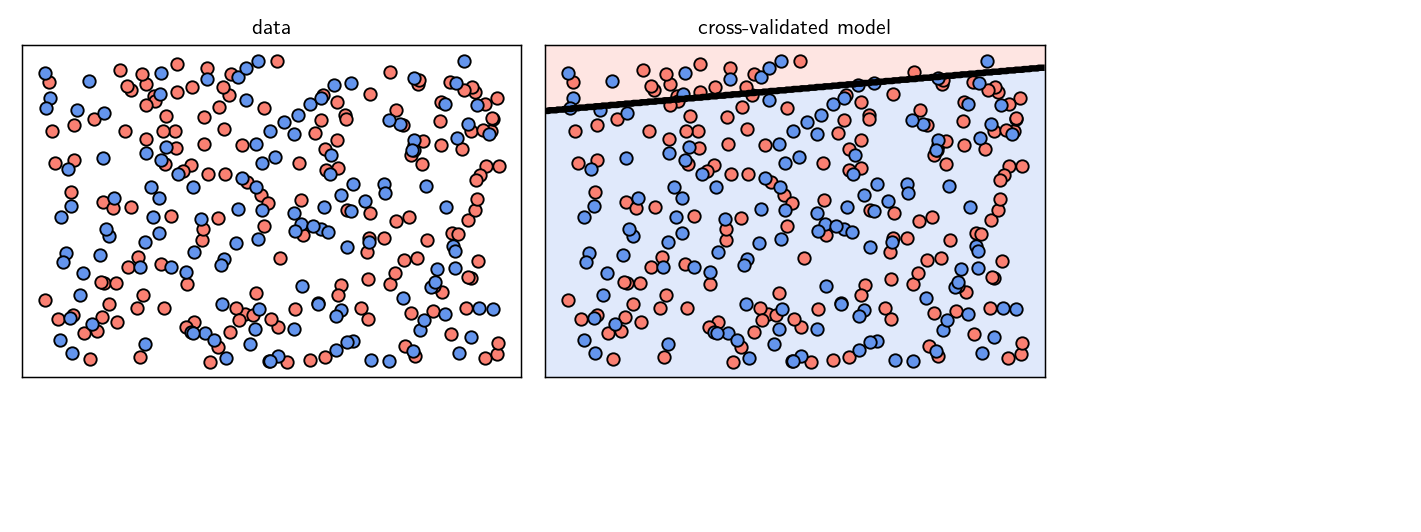

In [3]:
# load in dataset
csvname = datapath + 'random_2class.csv'
data = np.loadtxt(csvname,delimiter = ',')
x_orig = data[:-1,:]
y_orig = data[-1:,:] 

# split into original training and testing sets
all_inds = np.random.permutation(data.shape[1])
orig_inds = all_inds[:200]
x = x_orig[:,orig_inds]
y = y_orig[:,orig_inds] 

test_inds = all_inds[200:]
x_test = x_orig[:,test_inds]
y_test = y_orig[:,test_inds] 

# run bagg
degree = 15
num_baggs = 1
train_portion = 0.8
runs6 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib6 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib6.preprocessing_steps(name = 'none')
    
    # pluck out indices of current training / validation sets
    mylib6.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib6.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib6.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib6.fit(algo = 'newtons_method',max_its = 10,verbose = False,lam = 10**(-8),epsilon=10**(-3))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [np.min(mylib6.valid_count_histories[i]) for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    # get minor of minor
    smallest_ind = np.argmin(mylib6.valid_count_histories[min_ind])
    mylib6.train_cost_histories = mylib6.train_cost_histories[min_ind][smallest_ind]
    mylib6.valid_cost_histories = mylib6.valid_cost_histories[min_ind][smallest_ind]
    mylib6.train_count_histories = mylib6.train_count_histories[min_ind][smallest_ind]
    mylib6.valid_count_histories = mylib6.valid_count_histories[min_ind][smallest_ind]
    mylib6.weight_histories = mylib6.weight_histories[min_ind][smallest_ind]
    mylib6.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    runs6.append(copy.deepcopy(mylib6))
    
# print out accuracy on entire dataset
w = mylib6.weight_histories
valid_inds = mylib6.valid_inds
x_valid = x[:,valid_inds]
y_valid = y[:,valid_inds]
acc_valid = 1 - mylib6.counter(w,x_valid,y_valid)/np.size(y_valid)
print ('accuracy on validation set ' + str(np.round(100*acc_valid,2)) + '%')

# print out accuracy on entire dataset
acc = 1 - mylib6.counter(w,x,y)/np.size(y)
print ('accuracy on entire dataset ' + str(np.round(100*acc,2)) + '%')

# draw pics
demo6 = nonlib.classification_test_viz.Visualizer(csvname)
demo6.show_baggs(runs6,color_region=True)

The danger of overfitting to validation data is not limited to extreme examples such as the one above, and in principle can occur with general datasets when cross-validating a set of high capacity models.  While it is not as prevalant or severe as the overfitting that occurs with training-error minimized models, it is still a danger that in practice should be avoided when possible.  

## 11.6.2  Testing data and testing error

Up until now we have used validation data to *both* select the best model for our data (i.e., cross-validating) *and* to determine its quality.  However much like when the notion of validation data was first introduced in Section 11.2, we see that using the same set of data to perform both of these tasks can lead to the selection of an overfitting model and can diminish the utility of validation error as a measure of model quality.  The solution to this problem - again much like when we introduced the concept of validation data to begin with - is to divy up the two tasks we now assign to validation data by introducing a second validation set.  This 'second validation set' is often called a *test set / test data* or *testing set / testing data* and is used solely to judge the quality of our final cross-validated model.  

- After the cross-validated model is constructed its quality is measured on the testing data, on which it has neither been trained nor validated on.

- This testing error gives an unbiased estimate of the cross-validated model's performance, and is generally closer to capturing the true error of our model on 'future data generated by the same phenomenon'.

In the case of our random two-class data introduced above, such a testing set provides a far more accurate picture of how well our cross-validated model will work in general.  In the panels below we again show this dataset, only now we show both the validation data (those points highlighted with yellow boundaries) as well as with a testing portion of $100$ points (those points highlighted with green boundaries) that was removed when cross-validating and not shown above.  While our cross-validated model achieved $60\%$ accuracy on the validation set (as mentioned previously), it achieves only a $45\%$ accuracy on the testing set. The latter error clearly better depicts cross-validated model's true ability, which given the nature of how this data is generated we would expect in general to be no better than chance ($50\%$).

<IPython.core.display.Javascript object>


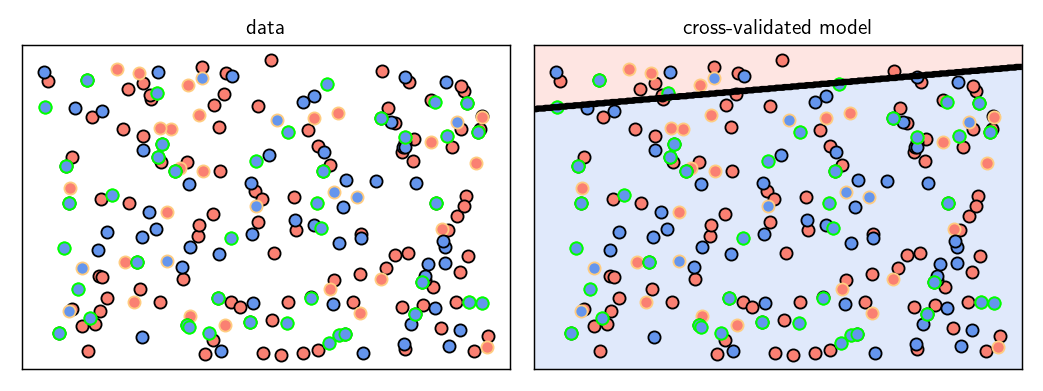

accuracy on test set 45.0%


In [9]:
# show training, validation, and testing data
demo6.show_train_test(runs6,x_test,y_test,color_region=True)

# print out accuracy on entire dataset
test_acc = 1 - mylib6.counter(w,x_test,y_test)/np.size(y_test)
print ('accuracy on test set ' + str(np.round(100*test_acc,2)) + '%')

### What portion of the original dataset should we assign to our testing set?

- As with the portioning of training and validation, there is no general rule for portioning.

- Note: the use of testing data is a luxury we can indulge in only when we have a large amount of data. When data is scarce we must leverage it all just to build a halfway reasonable cross-validated model.

- When data is plentiful, often the size of validation and testing sets are chosen similarly, e.g., if $\frac{1}{10}$ of a dataset is used for validation, often for simplicity the same portion is used for testing as well.